In [7]:
# Imports

import torch as nn
import mne
import mne_realtime as mne_rt


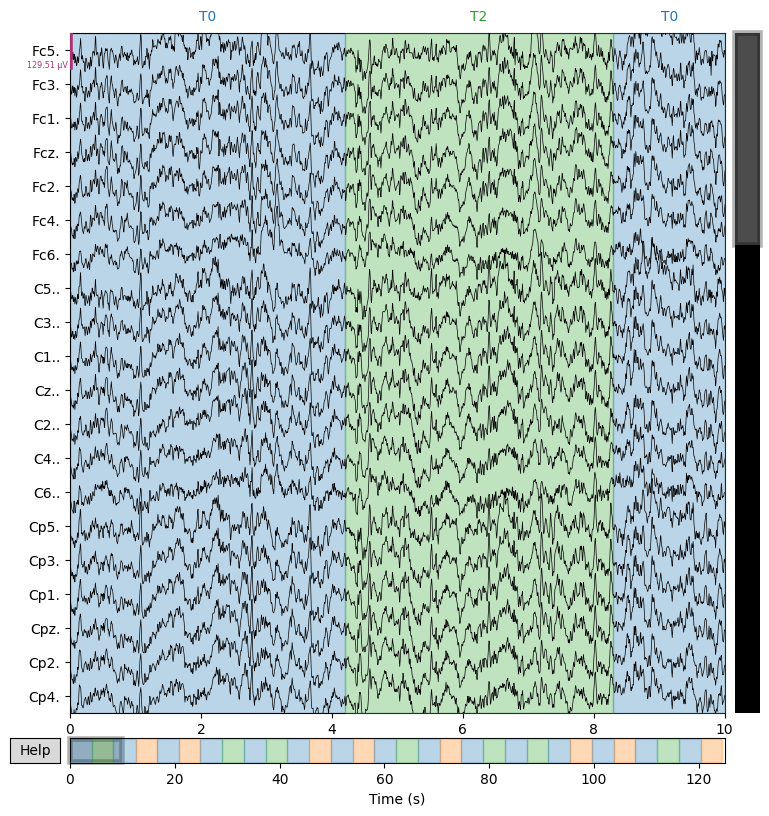

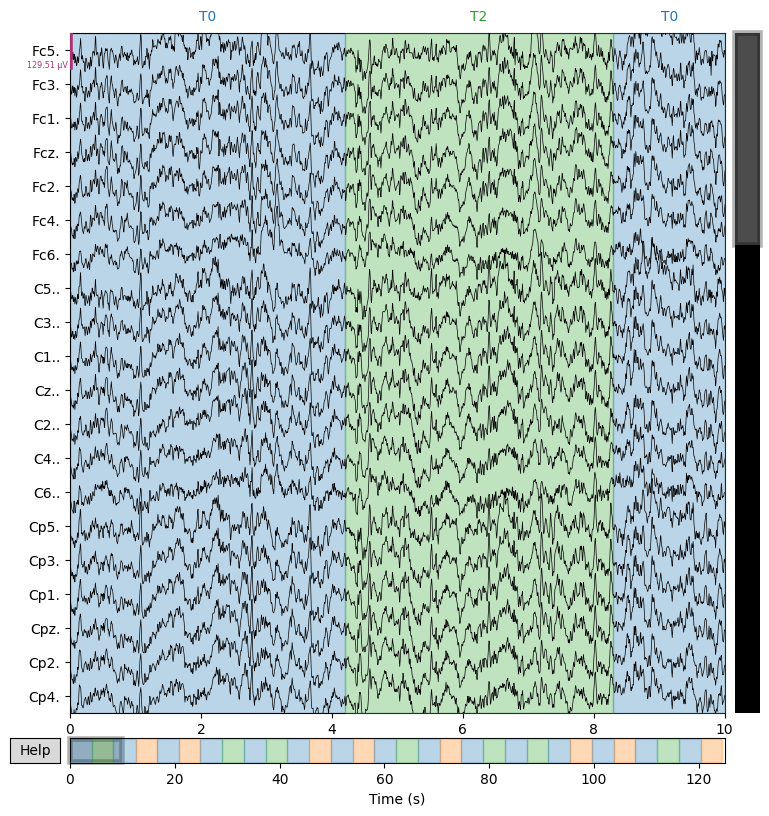

In [9]:
# This code will apply filters onto the EEG signals to extract relevant features for classification
raw_fnames = mne.datasets.eegbci.load_data(1, [3, 7])
raw = mne.io.read_raw_edf(raw_fnames[0], preload=True)
original_raw = raw.copy()

# We want to remove high frequency noise above 50hz
original_raw.filter(l_freq= None, h_freq = 50.0)

# We want to remove slow drifts below 0.1hz
original_raw.filter(l_freq = 0.1, h_freq = None)

# We want to remove power line noise at 50Hz and 60Hz
original_raw.notch_filter(freqs = [50, 60])


# Finally, we will pick only the EEG channels for further processing
original_raw.pick("eeg")
original_raw.plot(scalings = "auto")
